### Check the GPU

In [1]:
!nvidia-smi

Mon Sep 13 09:00:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3080    On   | 00000000:2B:00.0  On |                  N/A |
|  0%   33C    P8    15W / 340W |    537MiB / 10009MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import dependencies

In [2]:
import torch
import yaml
import glob
import matplotlib.pyplot as plt
import os

from utils.plots import plot_results
from IPython.display import Image
from IPython.core.magic import register_line_cell_magic

print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))
%matplotlib inline

Setup complete. Using torch 1.8.1+cu111 _CudaDeviceProperties(name='GeForce RTX 3080', major=8, minor=6, total_memory=10009MB, multi_processor_count=68)


### Create a custom yaml file with the custom classes

In [3]:
%cd chess_dataset/
filename = "data.yaml"

with open(filename, "w") as f:
    f.write("train: train/images\n")
    f.write("val: valid/images\n")
    f.write("\n")
    f.write("nc: 13\n")
    f.write("names: ['bishop', 'black-bishop', 'black-king', 'black-knight', 'black-pawn', 'black-queen', 'black-rook', 'white-bishop', 'white-king', 'white-knight', 'white-pawn', 'white-queen', 'white-rook']\n")
    f.close()
%cd ..

/home/rohan/object_detection/yolov5/chess_dataset
/home/rohan/object_detection/yolov5


In [4]:
%cat chess_dataset/data.yaml

train: train/images
val: valid/images

nc: 15
names: ['bishop', 'black-bishop', 'black-king', 'black-knight', 'black-pawn', 'black-queen', 'black-rook', 'white-bishop', 'white-king', 'white-knight', 'white-pawn', 'white-queen', 'white-rook']


### Resize the original dataset to a standard dataset (usually a multiple of 32)

In [5]:
!python3 pipeline_resize.py --dir chess_dataset/ --size 416

Created ./resized_dataset directory
Successfully copied all files to the resized_dataset folder
Resizing images...
100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 44620.26it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████| 202/202 [00:00<00:00, 2590976.78it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████| 58/58 [00:00<00:00, 1750141.24it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████| 29/29 [00:00<00:00, 1280366.48it/s]
Datset resized!


### Augment images in the dataset

In [6]:
!python3 pipeline_augmentation.py --n 4

Successfully copied all files to the Dataset folder


Before Augmentation:
Number of images in the train folder: 201
Number of images in the valid folder: 58
Number of images in the test folder: 29


yaml file read successfully!

Labels and Indices: 
{0: 'bishop', 1: 'black-bishop', 2: 'black-king', 3: 'black-knight', 4: 'black-pawn', 5: 'black-queen', 6: 'black-rook', 7: 'white-bishop', 8: 'white-king', 9: 'white-knight', 10: 'white-pawn', 11: 'white-queen', 12: 'white-rook'}


Directory: test: 100%|██████████████████████████| 29/29 [00:00<00:00, 67.44it/s]

Augmentation Complete!

After Augmentation:
Number of images in the train folder: 1005
Number of images in the valid folder: 58
Number of images in the test folder: 29

Removing redundant directories...
Redundant directories removed


### Plot the augmented images and the annotations as a sanity check

In [7]:
!python3 pipeline_visualize.py

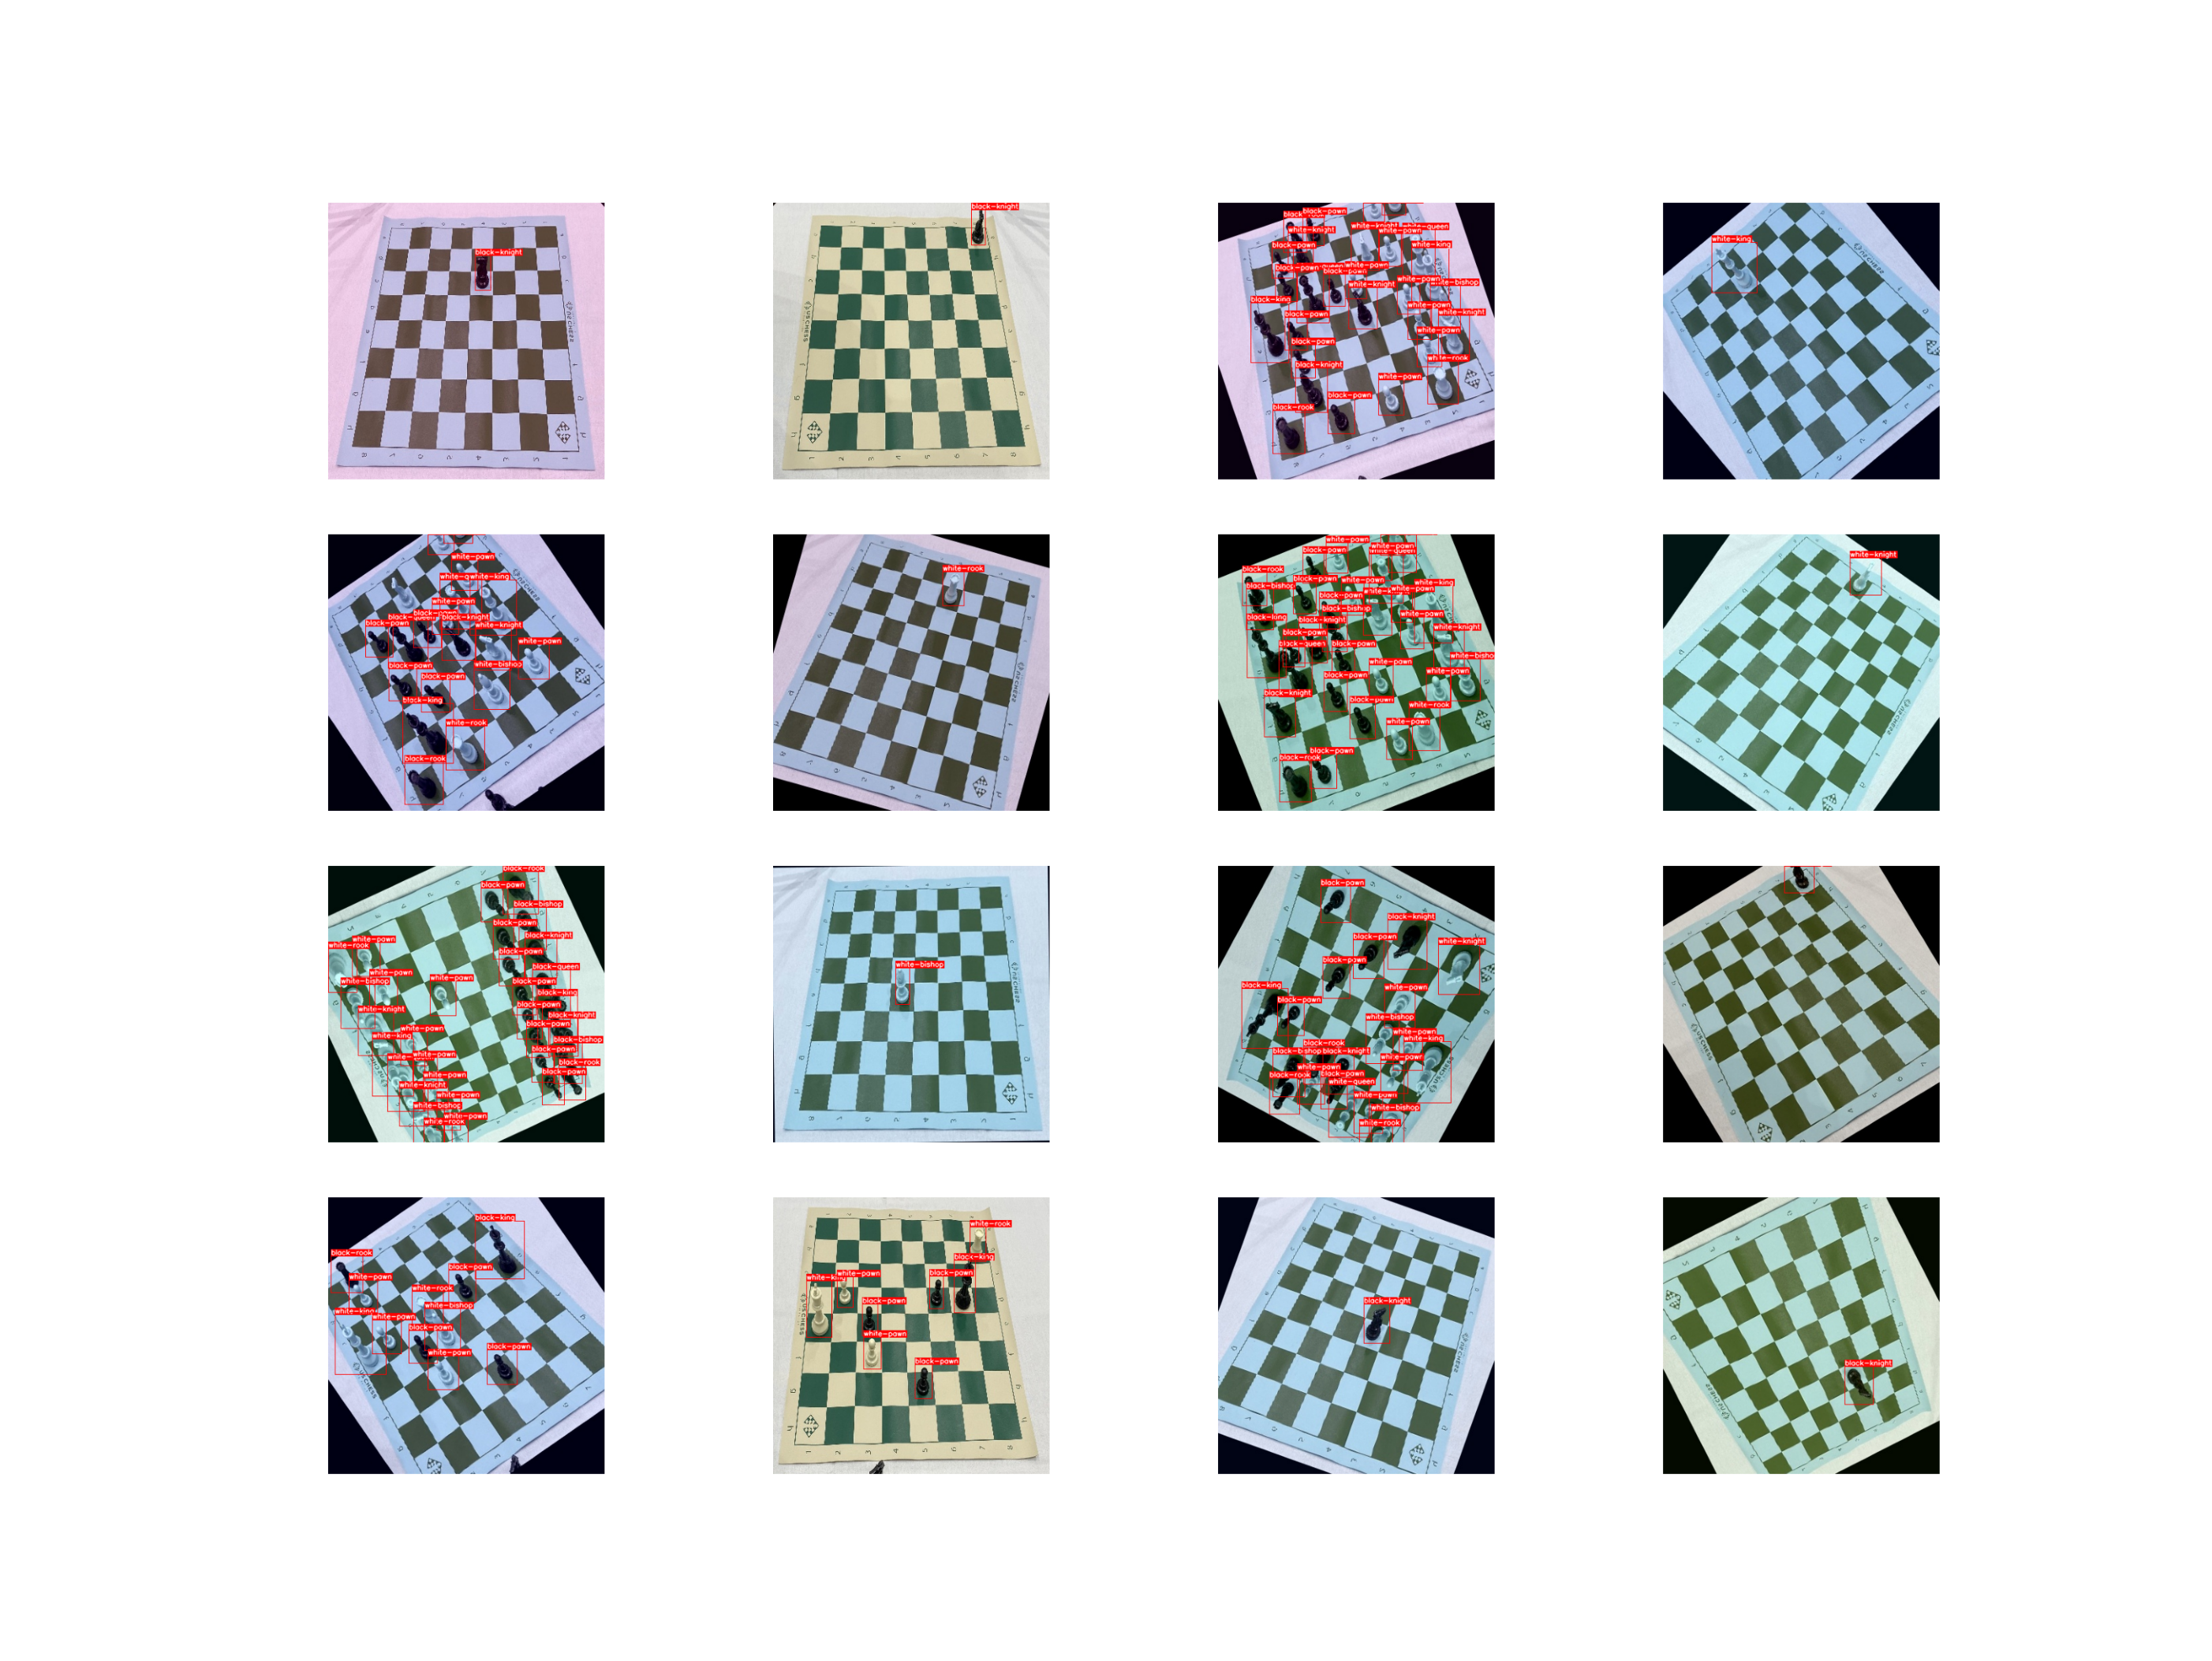

In [8]:
image = plt.imread("./augmented_images.png")
plt.figure(figsize = (50, 50))
plt.axis("off")
plt.imshow(image)
plt.show()

### Modify the yaml file for the augmented dataset

In [9]:
!rm dataset/data.yaml
%cd dataset/
filename = "data.yaml"

with open(filename, "w") as f:
    f.write(f"train: {os.getcwd()}/train/images\n")
    f.write(f"val: {os.getcwd()}/valid/images\n")
    f.write("\n")
    f.write("nc: 13\n")
    f.write("names: ['bishop', 'black-bishop', 'black-king', 'black-knight', 'black-pawn', 'black-queen', 'black-rook', 'white-bishop', 'white-king', 'white-knight', 'white-pawn', 'white-queen', 'white-rook']\n")
    f.close()
%cd ..

/home/rohan/object_detection/yolov5/dataset
/home/rohan/object_detection/yolov5


In [10]:
%cat dataset/data.yaml

train: /home/rohan/object_detection/yolov5/dataset/train/images
val: /home/rohan/object_detection/yolov5/dataset/valid/images

nc: 13
names: ['bishop', 'black-bishop', 'black-king', 'black-knight', 'black-pawn', 'black-queen', 'black-rook', 'white-bishop', 'white-king', 'white-knight', 'white-pawn', 'white-queen', 'white-rook']


### Select the number of classes as per the custom dataset

In [11]:
# define number of classes based on YAML
with open("dataset/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

### Choose the YOLOv5 architecture

In [12]:
%cat models/yolov5x.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 1.33  # model depth multiple
width_multiple: 1.25  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C

### Modify the architecture based on the number of classes and save it as a new file

In [13]:
@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [14]:
%%writetemplate models/custom_yolov5x.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 1.33  # model depth multiple
width_multiple: 1.25  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [15]:
%pwd

'/home/rohan/object_detection/yolov5'

### Start training the custom model

In [16]:
%%time
!python train.py --img 416 --batch 8 --epochs 200 --data dataset/data.yaml --cfg models/custom_yolov5x.yaml --weights yolov5x.pt --name yolov5x_results  --cache

github: skipping check (not a git repository)
YOLOv5 🚀 2021-8-4 torch 1.8.1+cu111 CUDA:0 (GeForce RTX 3080, 10009.625MB)

Namespace(adam=False, artifact_alias='latest', batch_size=8, bbox_interval=-1, bucket='', cache_images=True, cfg='models/custom_yolov5x.yaml', data='dataset/data.yaml', device='', entity=None, epochs=200, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[416, 416], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='yolov5x_results', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/yolov5x_results2', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=8, upload_dataset=False, weights='yolov5x.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epoc


     Epoch   gpu_mem       box       obj       cls     total    labels  img_size
    26/199      6.3G   0.03163   0.03597  0.008927   0.07653       177       416
               Class      Images      Labels           P           R      mAP@.5
                 all          58         386       0.986       0.992       0.986       0.777

     Epoch   gpu_mem       box       obj       cls     total    labels  img_size
    27/199      6.3G   0.03185   0.03684  0.008867   0.07755       121       416
               Class      Images      Labels           P           R      mAP@.5
                 all          58         386        0.99        0.99       0.986       0.723

     Epoch   gpu_mem       box       obj       cls     total    labels  img_size
    28/199      6.3G   0.03054    0.0367  0.008433   0.07567        79       416
               Class      Images      Labels           P           R      mAP@.5
                 all          58         386        0.99       0.991       0.986  

               Class      Images      Labels           P           R      mAP@.5
                 all          58         386        0.98       0.985       0.979       0.791

     Epoch   gpu_mem       box       obj       cls     total    labels  img_size
    75/199      6.3G   0.02319   0.03109  0.005466   0.05975        51       416
               Class      Images      Labels           P           R      mAP@.5
                 all          58         386        0.96       0.982       0.977       0.765

     Epoch   gpu_mem       box       obj       cls     total    labels  img_size
    76/199      6.3G   0.02238   0.02932  0.005653   0.05735       113       416
               Class      Images      Labels           P           R      mAP@.5
                 all          58         386       0.963       0.984        0.98        0.79

     Epoch   gpu_mem       box       obj       cls     total    labels  img_size
    77/199      6.3G   0.02315   0.02883  0.005444   0.05743       116


     Epoch   gpu_mem       box       obj       cls     total    labels  img_size
    99/199      6.3G   0.02155   0.02768  0.005175    0.0544       116       416
               Class      Images      Labels           P           R      mAP@.5
                 all          58         386       0.982       0.978       0.987       0.794

     Epoch   gpu_mem       box       obj       cls     total    labels  img_size
   100/199      6.3G   0.02078   0.02759  0.005127   0.05349       152       416
               Class      Images      Labels           P           R      mAP@.5
                 all          58         386       0.981       0.987       0.985       0.789

     Epoch   gpu_mem       box       obj       cls     total    labels  img_size
   101/199      6.3G   0.02093   0.02698  0.005172   0.05308       161       416
               Class      Images      Labels           P           R      mAP@.5
                 all          58         386       0.988       0.987       0.986  

               Class      Images      Labels           P           R      mAP@.5
                 all          58         386        0.98       0.982       0.989       0.799

     Epoch   gpu_mem       box       obj       cls     total    labels  img_size
   148/199      6.3G   0.01708   0.02125  0.004093   0.04241       166       416
               Class      Images      Labels           P           R      mAP@.5
                 all          58         386       0.985       0.973       0.985       0.797

     Epoch   gpu_mem       box       obj       cls     total    labels  img_size
   149/199      6.3G    0.0169   0.02205  0.004172   0.04311        96       416
               Class      Images      Labels           P           R      mAP@.5
                 all          58         386       0.981       0.966       0.985       0.796

     Epoch   gpu_mem       box       obj       cls     total    labels  img_size
   150/199      6.3G   0.01655   0.02227  0.004035   0.04285       105


     Epoch   gpu_mem       box       obj       cls     total    labels  img_size
   172/199      6.3G   0.01576     0.021  0.003935   0.04069        77       416
               Class      Images      Labels           P           R      mAP@.5
                 all          58         386       0.988       0.977       0.988       0.793

     Epoch   gpu_mem       box       obj       cls     total    labels  img_size
   173/199      6.3G   0.01629   0.02064  0.003926   0.04086       138       416
               Class      Images      Labels           P           R      mAP@.5
                 all          58         386       0.986       0.984       0.988         0.8

     Epoch   gpu_mem       box       obj       cls     total    labels  img_size
   174/199      6.3G   0.01558   0.01905  0.003905   0.03854        81       416
               Class      Images      Labels           P           R      mAP@.5
                 all          58         386       0.989       0.979       0.988  

### Display the training process graphs

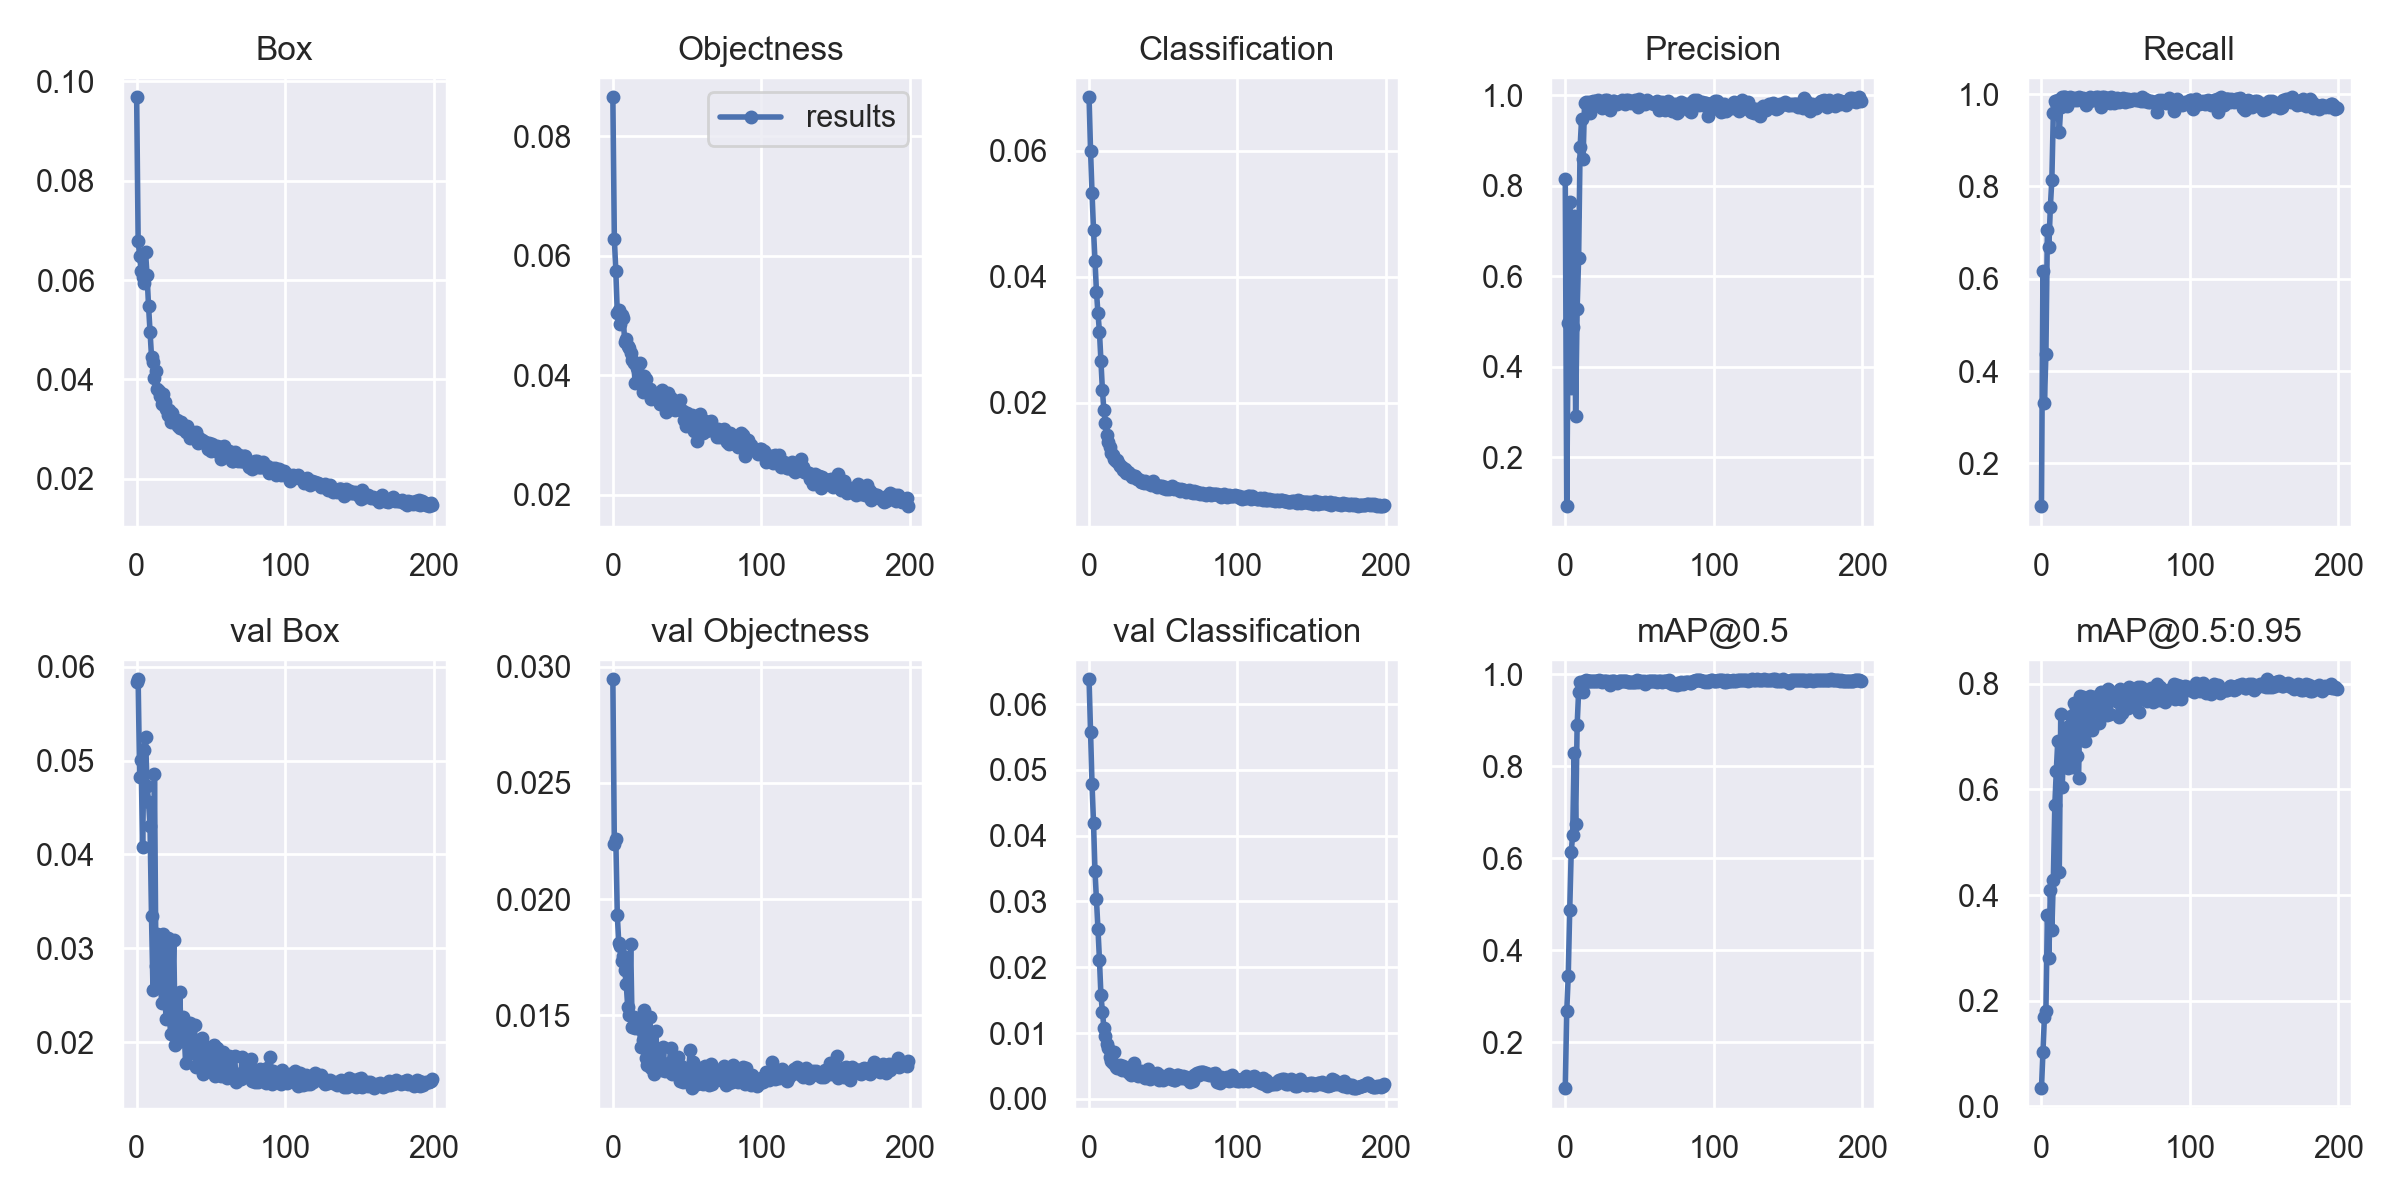

In [17]:
Image(filename = "/home/rohan/object_detection/yolov5/runs/train/yolov5x_results2/results.png", width = 1000)

### Run inference on test data

In [18]:
!python detect.py --weights runs/train/yolov5x_results2/weights/best.pt --img 416 --conf 0.4 --source dataset/test/images

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, hide_conf=False, hide_labels=False, img_size=416, iou_thres=0.45, line_thickness=3, max_det=1000, name='exp', nosave=False, project='runs/detect', save_conf=False, save_crop=False, save_txt=False, source='dataset/test/images', update=False, view_img=False, weights=['runs/train/yolov5x_results2/weights/best.pt'])
YOLOv5 🚀 2021-8-4 torch 1.8.1+cu111 CUDA:0 (GeForce RTX 3080, 10009.625MB)

Fusing layers... 
Model Summary: 476 layers, 87279442 parameters, 0 gradients, 217.3 GFLOPS
image 1/29 /home/rohan/object_detection/yolov5/dataset/test/images/0b47311f426ff926578c9d738d683e76_jpg.rf.0b55f43ac16aa65c889558d8ea757072.jpg: 416x416 1 white-bishop, Done. (0.017s)
image 2/29 /home/rohan/object_detection/yolov5/dataset/test/images/1c0060ef868bdc326ce5e6389cb6732f_jpg.rf.9ce88078ea356949f4ab7ad9cfdfc62d.jpg: 416x416 1 white-rook, Done. (0.016s)
image 3/29 /home/rohan/object_detection/yolov5/dat

### Display images from the test data

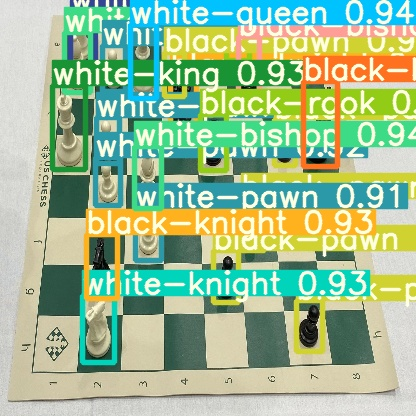

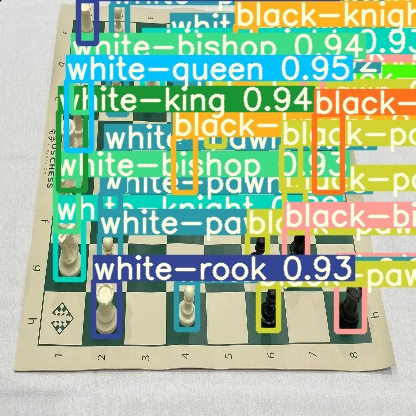

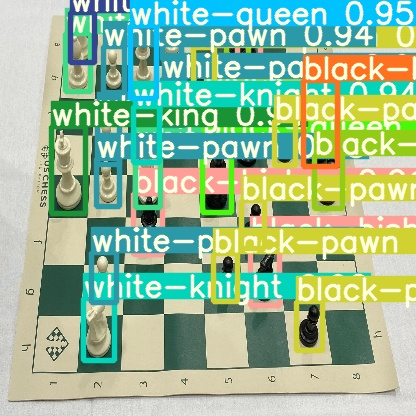

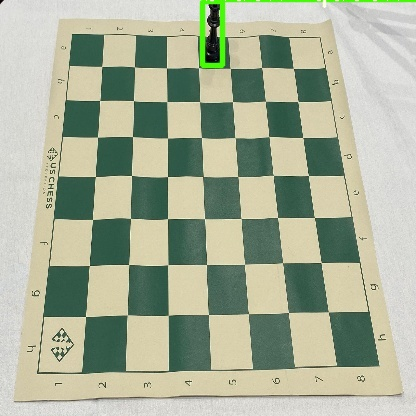

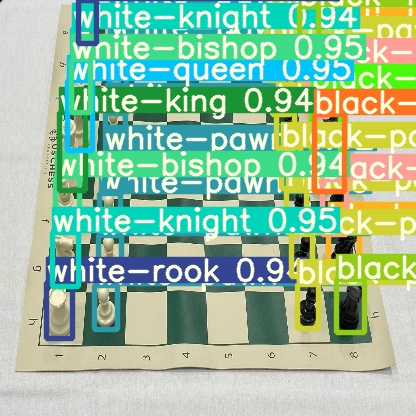

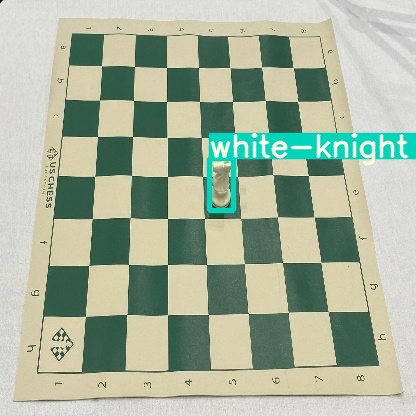

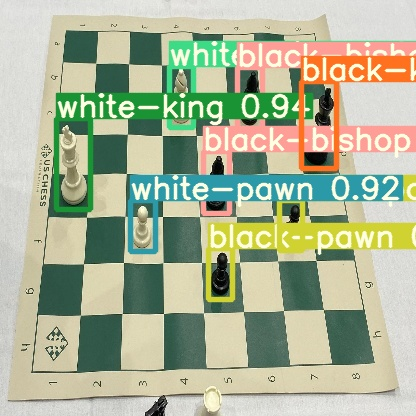

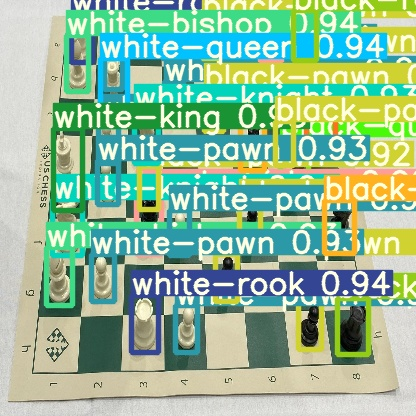

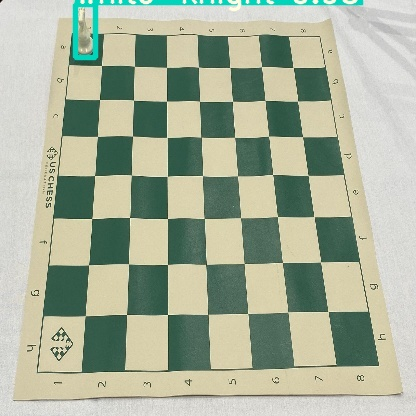

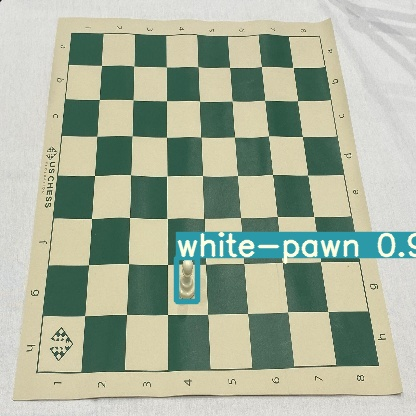

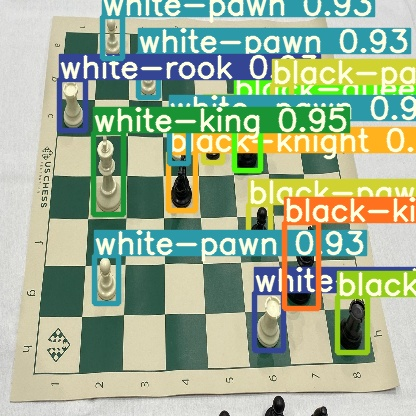

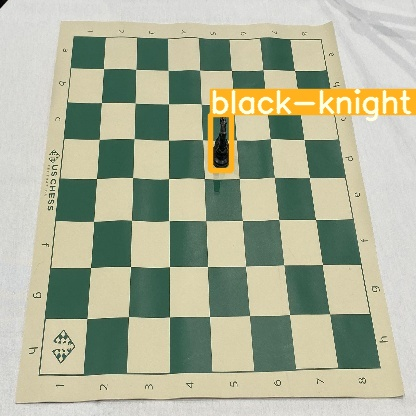

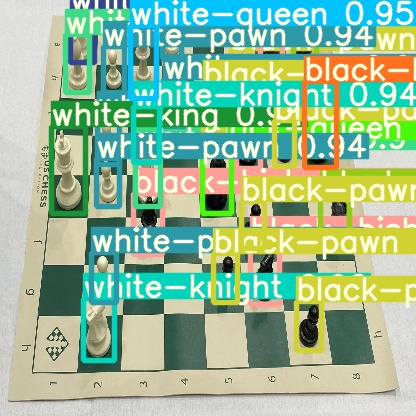

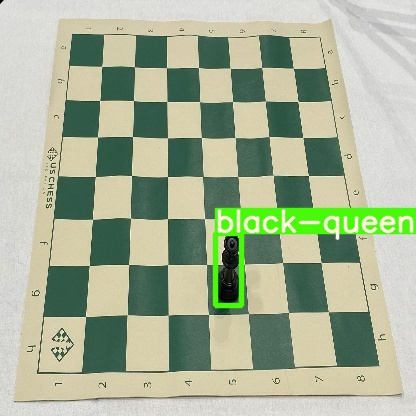

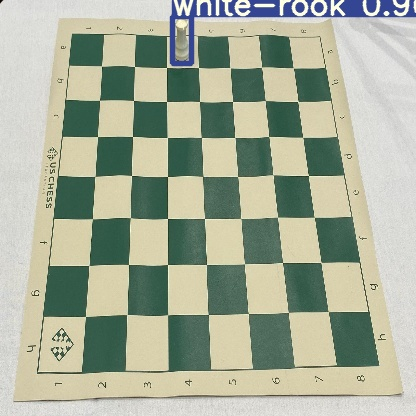

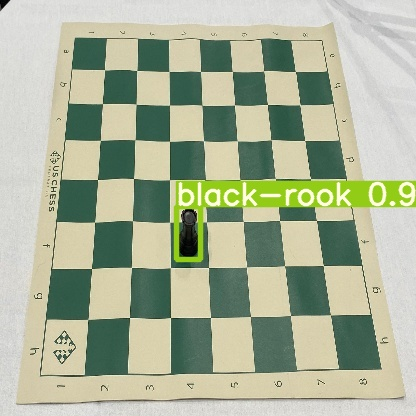

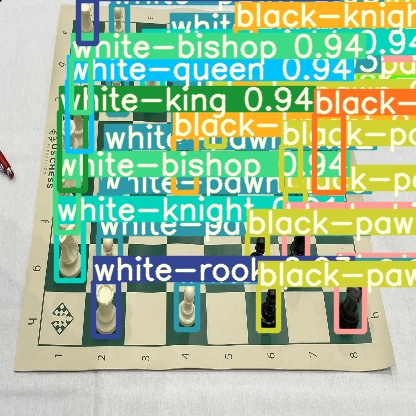

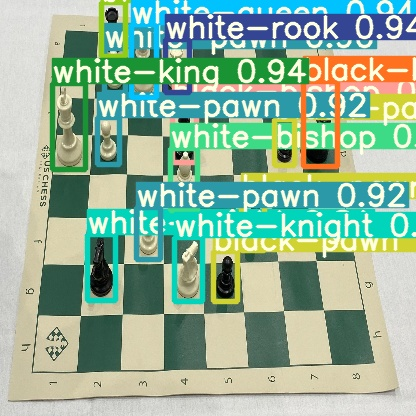

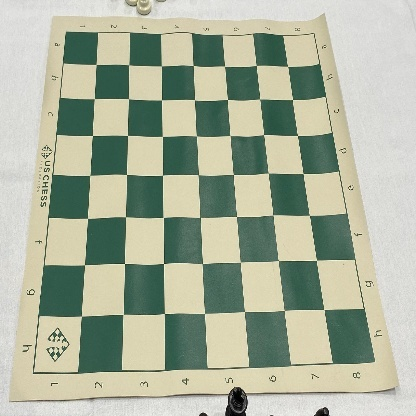

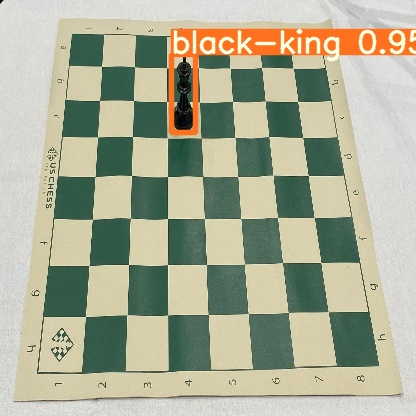

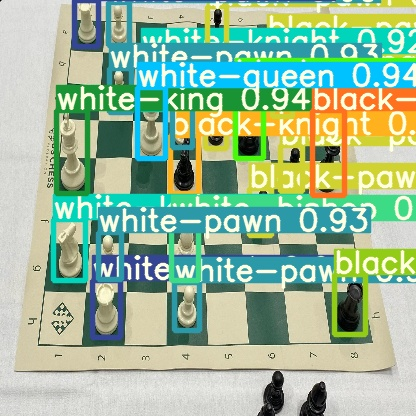

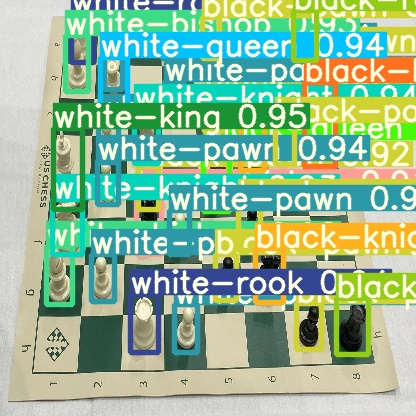

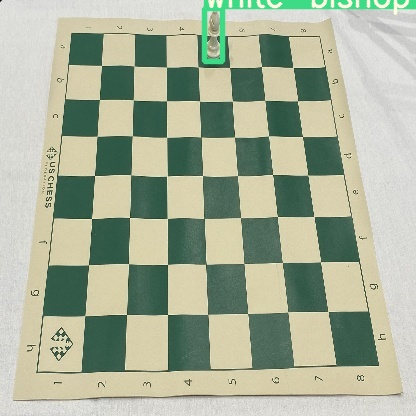

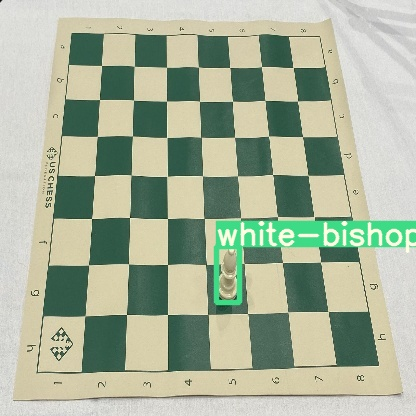

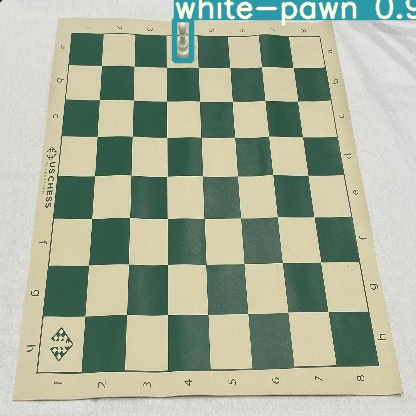

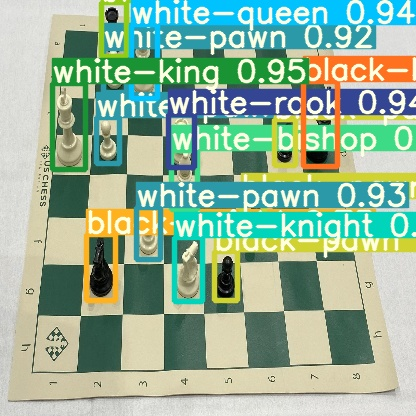

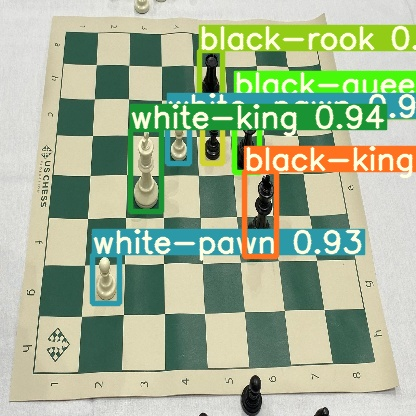

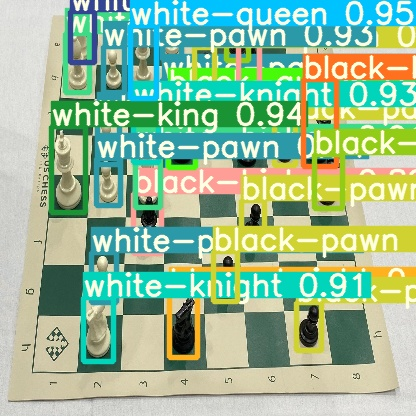

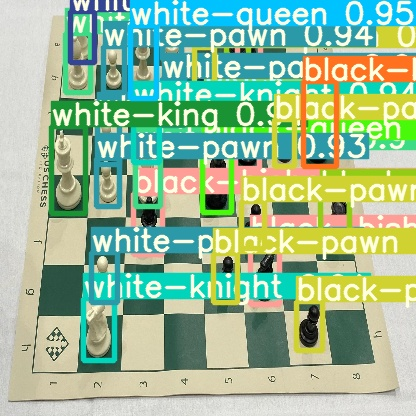

In [20]:
for imageName in glob.glob('runs/detect/exp12/*.jpg'):
    display(Image(filename = imageName))
    print("\n")